In [1]:
using Plots
include("coevolution_network_base.jl")
using .CoevolutionNetworkBase
using Printf
theme(:dracula)

In [45]:
# Parameters
L = 40.0
dx = 0.8
x = -L/2:dx:L/2-dx
r = 2.5
M = 15
beta = 2.5
alpha = 0.0
gamma = 1.0
# D = 0.0025
D = 0.00
Nh = 2 * 10^6
stochastic = false
sigma = 1

# Initialize viral and immune densities
viral_density = zeros(Float64, length(x))
viral_density[Int(round(length(x)/2))] = 100/dx

# initial_variance = 0.1
# viral_density .= 100/sqrt(2 * pi * initial_variance) .* exp.(-x.^2/2/initial_variance)
viral_density2 = zeros(Float64, length(x))
immune_density = zeros(Float64, length(x))

# Create Population instances
population = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=stochastic, sigma=sigma)
population2 = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density2, immune_density; stochastic=stochastic, sigma=sigma)
populations = [population, population2]

# populations[1] = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=true)

# Create Network instance
migration_matrix = 0.0 * ones(size(populations,1),size(populations,1)) # Define an appropriate migration matrix
println(size(migration_matrix,1))
network = Network(populations, migration_matrix);

# Create Simulation instance
dt = 0.05 # Define an appropriate time step size
duration = 80.0 # Define an appropriate simulation duration
simulation = Simulation(network, dt, duration; thin_by=20);

@time run_simulation!(simulation);

total_infected_per_deme = calculate_total_infected_per_deme(simulation)
println(total_infected_per_deme[1,end] > 0)

2
  0.152599 seconds (1 allocation: 736 bytes)
true


┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\danws\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191


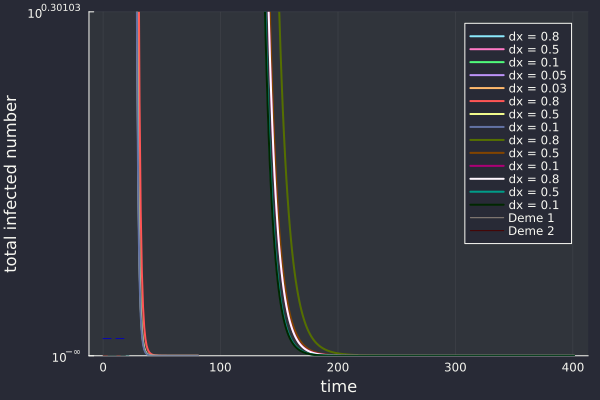

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\danws\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\danws\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\danws\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\danws\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\danws\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\danws\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191


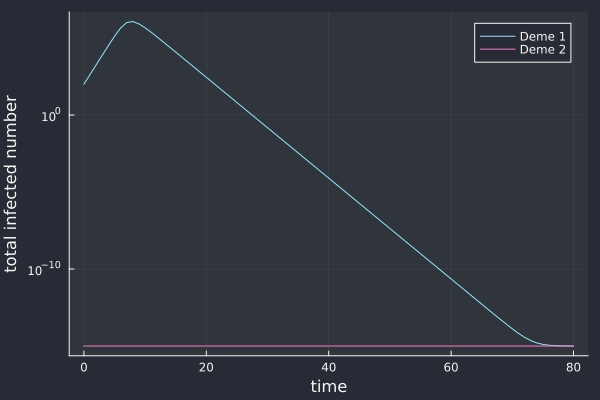

LoadError: UndefVarError: `p3` not defined

In [46]:
variances_per_deme = calculate_antigenic_variance_per_deme(simulation)
total_infected_per_deme = calculate_total_infected_per_deme(simulation)

# Number of demes
num_demes = size(total_infected_per_deme, 1)

# Plot for Variance of Antigenicity vs Time
treg = simulation.duration_times .< 20
# p = plot(;xlabel="Time", ylabel="Variance of antigenicity", background_color=:black)
# p2 = plot(xlabel="Time", ylabel="Total Infected", background_color=:black, yscale=:log, legend=:best)
# p3 = plot(xlabel="Total Infected", ylabel="Variance of antigenicity", xscale=:log10, legend=:topleft, background_color=:black)


for deme in 1:num_demes
    plot!(p, simulation.duration_times[treg], variances_per_deme[deme, treg], label="Deme $deme")
end
plot!(p, simulation.duration_times[treg], 0.1 .+ 2 * D * simulation.duration_times[treg], linestyle=:dash, label=:none)
plot!(p, simulation.duration_times[treg] .+ 4.3, 2 * D * simulation.duration_times[treg], linestyle=:dash, label=:none)
plot!(p, ylim=(0,2))
display(p)

# Plot for Total Infected vs Time
treg = simulation.duration_times .< 90

# Manually setting y-axis ticks for each order of magnitude
# yticks = [10^i for i in 0:7]; plot!(p2, yticks=yticks)
for deme in 1:num_demes
    plot!(p2, simulation.duration_times[treg], total_infected_per_deme[deme, treg] .+ 10^-15, label="Deme $deme")
end
# plot!(p2, simulation.duration_times[treg] .- 4.3, total_infected_per_deme[2, treg] .+ 10^-15, label="Deme 2, shifted", xlim=(0,Inf))
display(p2)

for deme in 1:num_demes
    # Find the index where the total infected per deme attains its maximum for the first time
    max_index = findfirst(==(maximum(total_infected_per_deme[deme, :])), total_infected_per_deme[deme, :])

    # Create the Boolean mask
    # reg = (total_infected_per_deme[deme, :] .> 100) .& (variances_per_deme[deme, :] .> 0) .& (1:length(total_infected_per_deme[deme, :]) .< max_index)
    reg = (total_infected_per_deme[deme, :] .> 0) .& (simulation.duration_times .<  simulation.duration_times[argmax(total_infected_per_deme[deme, 1:50])])
    
    # Plot using the mask
    plot!(p3, total_infected_per_deme[deme, reg], variances_per_deme[deme, reg], label="Deme $deme")
end
display(p3)

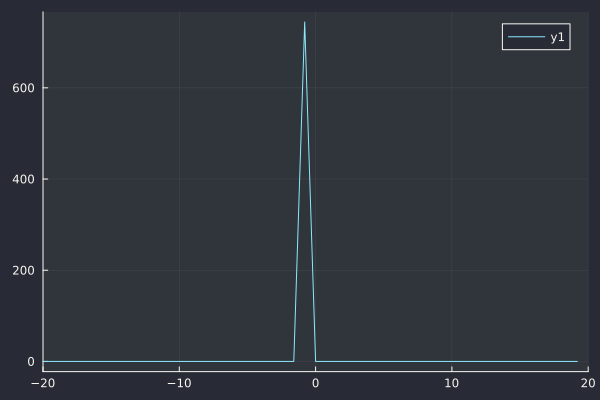

In [29]:
t_idx = 20
plot(x, simulation.trajectory[t_idx].populations[1].viral_density, xlim=(-20,20))
# p2 = twinx(p)
# plot!(p2, x, simulation.trajectory[t_idx].populations[1].fitness, ylim =(0, 1.55))

Testing the diffusion 

 16.942059 seconds (1 allocation: 736 bytes)
true


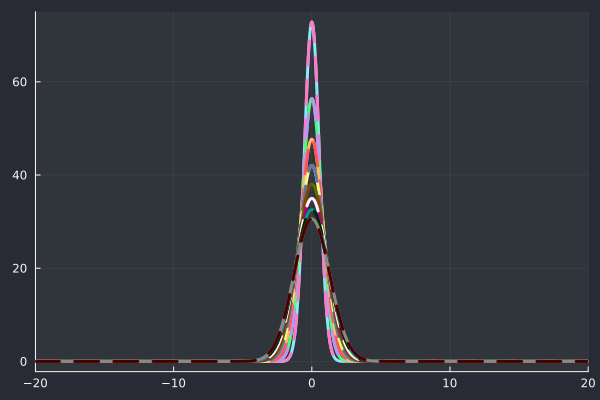

In [34]:
# Parameters
L = 40.0
dx = 0.05
x = -L/2:dx:L/2-dx
r = 2.5
M = 15
beta = 0.0
alpha = 0.0
gamma = 0.0
# D = 0.0025
D = 0.01
Nh = 2 * 10^6
stochastic = false
sigma = 1

# Initialize viral and immune densities
viral_density = zeros(Float64, length(x))
viral_density[Int(round(length(x)/2))] = 100/dx

initial_variance = 0.3
viral_density .= 100/sqrt(2 * pi * initial_variance) .* exp.(-x.^2/2/initial_variance)
immune_density = zeros(Float64, length(x))

# Create Population instances
population = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=stochastic, sigma=sigma)
populations = [population]

# populations[1] = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=true)

# Create Network instance
migration_matrix = 0.0 * ones(size(populations,1),size(populations,1)) # Define an appropriate migration matrix
network = Network(populations, migration_matrix);

# Create Simulation instance
dt = 0.05 # Define an appropriate time step size
duration = 80.0 # Define an appropriate simulation duration
simulation = Simulation(network, dt, duration; thin_by=20);

@time run_simulation!(simulation);

total_infected_per_deme = calculate_total_infected_per_deme(simulation)
println(total_infected_per_deme[1,end] > 0)

p = plot(legend=false)
for t_idx = 1:10:80
    curr_var = initial_variance + 2 * D * simulation.duration_times[t_idx]
    plot!(p, x, simulation.trajectory[t_idx].populations[1].viral_density, xlim=(-20,20), lw=3)
    plot!(p, x, 100 / sqrt(2 * pi * curr_var) .* exp.(-x.^2 /2/curr_var), linestyle=:dash, lw=3)
end
display(p)

Testing the dynamics

  0.343526 seconds (1 allocation: 736 bytes)
  0.878771 seconds (1 allocation: 736 bytes)
 21.101402 seconds (1 allocation: 736 bytes)
 87.638695 seconds (1 allocation: 736 bytes)
298.792275 seconds (1 allocation: 736 bytes)


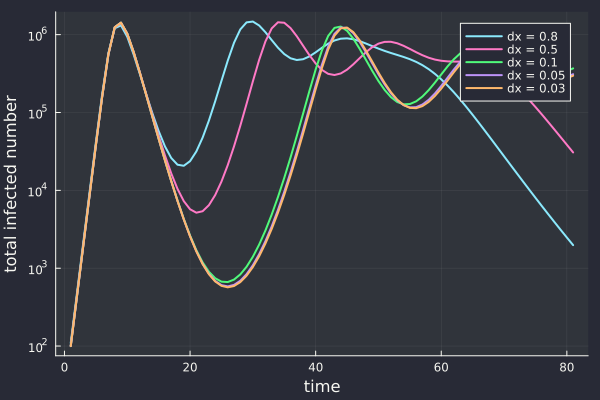

In [41]:
dx_values = [0.8, 0.5, 0.1, 0.05, 0.03]

p = plot(xlabel = "time", ylabel="total infected number", yscale=:log10)
for i in eachindex(dx_values)      
    # Parameters
    L = 40.0
    dx = dx_values[i]
    x = -L/2:dx:L/2-dx
    r = 2.5
    M = 15
    beta = 2.5
    alpha = 0.0
    gamma = 1.0
    # D = 0.0025
    D = 0.01
    Nh = 2 * 10^6
    stochastic = false
    sigma = 1

    # Initialize viral and immune densities
    viral_density = zeros(Float64, length(x))
    # viral_density[Int(round(length(x)/2))] = 100/dx

    initial_variance = 0.1
    viral_density .= 100/sqrt(2 * pi * initial_variance) .* exp.(-x.^2/2/initial_variance)
    immune_density = zeros(Float64, length(x))

    # Create Population instances
    population = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=stochastic, sigma=sigma)
    populations = [population]

    # populations[1] = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=true)

    # Create Network instance
    migration_matrix = 0.0 * ones(size(populations,1),size(populations,1)) # Define an appropriate migration matrix
    network = Network(populations, migration_matrix);

    # Create Simulation instance
    dt = 0.01 # Define an appropriate time step size
    duration = 80.0 # Define an appropriate simulation duration
    simulation = Simulation(network, dt, duration; thin_by=100);

    @time run_simulation!(simulation);

    total_infected_per_deme = calculate_total_infected_per_deme(simulation)
    plot!(p, total_infected_per_deme[1,:], lw=2, label="dx = $(dx)")
end
display(p)

it seems like dx = 0.1 is pretty converged, this can be checked in the no diffusion case which should look like SIR

CFL:0.0
  0.354369 seconds (1 allocation: 3.312 KiB)
CFL:0.0
  0.990035 seconds (1 allocation: 3.312 KiB)
CFL:0.0
 24.752207 seconds (1 allocation: 3.312 KiB)


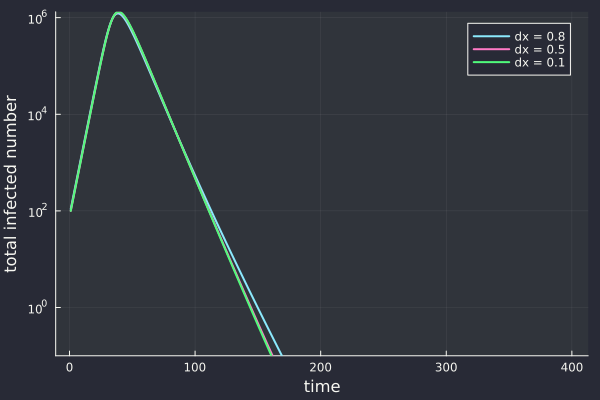

In [54]:
dx_values = [0.8, 0.5, 0.1]

p2 = plot(xlabel = "time", ylabel="total infected number", yscale=:log10, ylim=(0.1, Inf))
for i in eachindex(dx_values)      
    # Parameters
    L = 40.0
    dx = dx_values[i]
    x = -L/2:dx:L/2-dx
    r = 3.0
    M = 15
    beta = 2.5
    alpha = 0.0
    gamma = 1.0
    # D = 0.0025
    D = 0.0
    Nh = 2 * 10^6
    stochastic = false
    sigma = 1

    # Initialize viral and immune densities
    viral_density = zeros(Float64, length(x))
    # viral_density[Int(round(length(x)/2))] = 100/dx

    initial_variance = 0.1
    viral_density .= 100/sqrt(2 * pi * initial_variance) .* exp.(-x.^2/2/initial_variance)
    immune_density = zeros(Float64, length(x))

    # Create Population instances
    population = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=stochastic, sigma=sigma)
    populations = [population]

    # populations[1] = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=true)

    # Create Network instance
    migration_matrix = 0.0 * ones(size(populations,1),size(populations,1)) # Define an appropriate migration matrix
    network = Network(populations, migration_matrix);

    # Create Simulation instance
    dt = 0.01 # Define an appropriate time step size
    duration = 80.0 # Define an appropriate simulation duration
    simulation = Simulation(network, dt, duration; thin_by=20);

    println("CFL:", D * dt / dx^2)
    @time run_simulation!(simulation);
    total_infected_per_deme = calculate_total_infected_per_deme(simulation)
    plot!(p2, total_infected_per_deme[1,:], lw=2, label="dx = $(dx)")
end
display(p2)

Now with noise

CFL:0.0
  0.451682 seconds (1 allocation: 3.312 KiB)
CFL:0.0
  1.019931 seconds (1 allocation: 3.312 KiB)
CFL:0.0
 24.277193 seconds (1 allocation: 3.312 KiB)


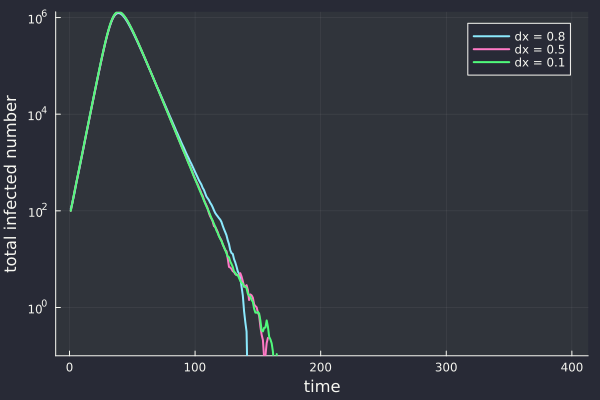

In [55]:
dx_values = [0.8, 0.5, 0.1]

p2 = plot(xlabel = "time", ylabel="total infected number", yscale=:log10, ylim=(0.1, Inf))
for i in eachindex(dx_values)      
    # Parameters
    L = 40.0
    dx = dx_values[i]
    x = -L/2:dx:L/2-dx
    r = 3.0
    M = 15
    beta = 2.5
    alpha = 0.0
    gamma = 1.0
    # D = 0.0025
    D = 0.0
    Nh = 2 * 10^6
    stochastic = true
    sigma = 1

    # Initialize viral and immune densities
    viral_density = zeros(Float64, length(x))
    # viral_density[Int(round(length(x)/2))] = 100/dx

    initial_variance = 0.1
    viral_density .= 100/sqrt(2 * pi * initial_variance) .* exp.(-x.^2/2/initial_variance)
    immune_density = zeros(Float64, length(x))

    # Create Population instances
    population = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=stochastic, sigma=sigma)
    populations = [population]

    # populations[1] = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=true)

    # Create Network instance
    migration_matrix = 0.0 * ones(size(populations,1),size(populations,1)) # Define an appropriate migration matrix
    network = Network(populations, migration_matrix);

    # Create Simulation instance
    dt = 0.01 # Define an appropriate time step size
    duration = 80.0 # Define an appropriate simulation duration
    simulation = Simulation(network, dt, duration; thin_by=20);

    println("CFL:", D * dt / dx^2)
    @time run_simulation!(simulation);
    total_infected_per_deme = calculate_total_infected_per_deme(simulation)
    plot!(p2, total_infected_per_deme[1,:], lw=2, label="dx = $(dx)")
end
display(p2)

Now with noise and diffusion 

CFL:3.9062499999999994e-5
  0.361288 seconds (1 allocation: 3.312 KiB)
CFL:0.0001
  0.896932 seconds (1 allocation: 3.312 KiB)
CFL:0.0024999999999999996
 24.329797 seconds (1 allocation: 3.312 KiB)


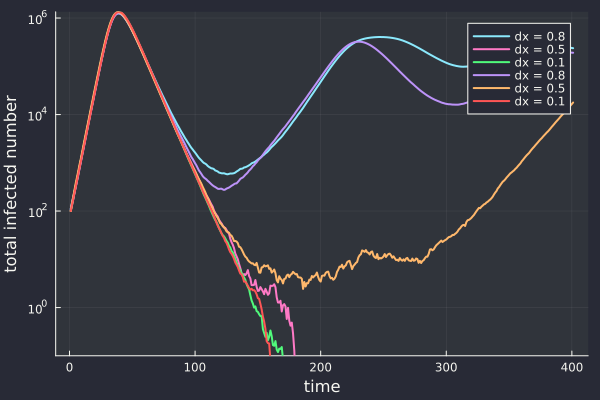

In [57]:
dx_values = [0.8, 0.5, 0.1]

# p2 = plot(xlabel = "time", ylabel="total infected number", yscale=:log10, ylim=(0.1, Inf))
for i in eachindex(dx_values)      
    # Parameters
    L = 40.0
    dx = dx_values[i]
    x = -L/2:dx:L/2-dx
    r = 3.0
    M = 15
    beta = 2.5
    alpha = 0.0
    gamma = 1.0
    D = 0.0025
    # D = 0.0
    Nh = 2 * 10^6
    stochastic = true
    sigma = 1

    # Initialize viral and immune densities
    viral_density = zeros(Float64, length(x))
    # viral_density[Int(round(length(x)/2))] = 100/dx

    initial_variance = 0.1
    viral_density .= 100/sqrt(2 * pi * initial_variance) .* exp.(-x.^2/2/initial_variance)
    immune_density = zeros(Float64, length(x))

    # Create Population instances
    population = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=stochastic, sigma=sigma)
    populations = [population]

    # populations[1] = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=true)

    # Create Network instance
    migration_matrix = 0.0 * ones(size(populations,1),size(populations,1)) # Define an appropriate migration matrix
    network = Network(populations, migration_matrix);

    # Create Simulation instance
    dt = 0.01 # Define an appropriate time step size
    duration = 80.0 # Define an appropriate simulation duration
    simulation = Simulation(network, dt, duration; thin_by=20);

    println("CFL:", D * dt / dx^2)
    @time run_simulation!(simulation);
    total_infected_per_deme = calculate_total_infected_per_deme(simulation)
    plot!(p2, total_infected_per_deme[1,:], lw=2, label="dx = $(dx)")
end
display(p2)